In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [16]:
penguins = sns.load_dataset('penguins')
data = penguins.dropna()

In [17]:
data['species'] = data['species'].map({'Adelie':0,'Chinstrap':1,'Gentoo':2})
#data['sex']=data['sex'].map({'Male':0,'Female':1})

C:\Users\HP\AppData\Local\Temp\ipykernel_8304\1116229410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['species'] = data['species'].map({'Adelie':0,'Chinstrap':1,'Gentoo':2})


In [18]:
targets = np.asarray(data['species'])
marker_style = ['o','s','^']
target_names = ['Adelie', 'Chinstrap','Gentoo']

In [19]:
data.drop(['island'],axis=1,inplace=True)
data.drop('sex',inplace=True,axis=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_8304\3007843347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['island'],axis=1,inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_8304\3007843347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('sex',inplace=True,axis=1)


In [20]:
data.columns

Index(['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g'],
      dtype='object')

In [21]:
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g']
X = data[features]
y = data['species']

Accuracy: 1.0


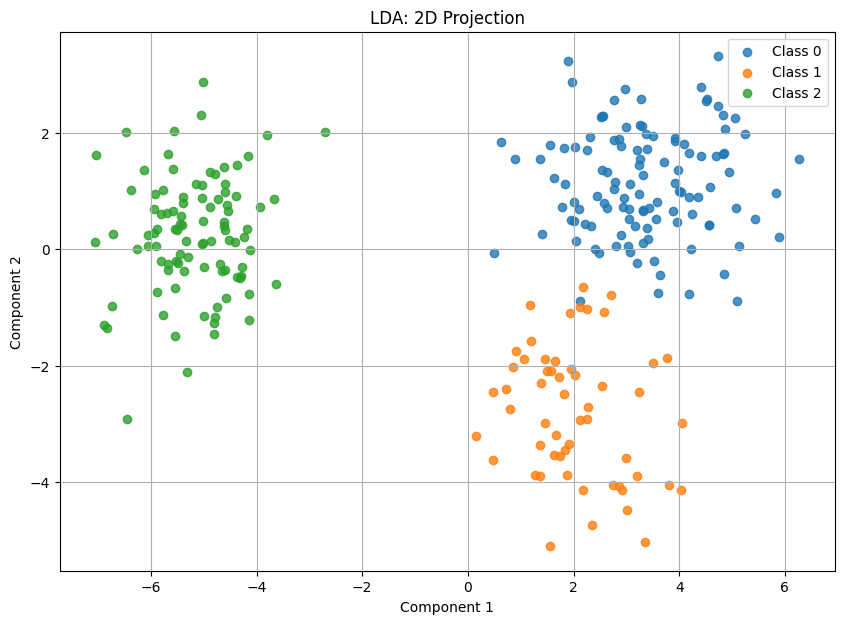

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features (optional but recommended for LDA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the LDA model
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# Make predictions
y_pred = lda.predict(X_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plotting the data in 2D
plt.figure(figsize=(10, 7))
for i, target_name in enumerate(set(y)):
    plt.scatter(X_train_lda[y_train == target_name, 0], X_train_lda[y_train == target_name, 1], alpha=0.8, label=f"Class {target_name}")
plt.legend()
plt.title('LDA: 2D Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

# If you have more than 2 components, you can plot in 3D (optional)
if X_train_lda.shape[1] > 2:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    for i, target_name in enumerate(set(y)):
        ax.scatter(X_train_lda[y_train == target_name, 0], X_train_lda[y_train == target_name, 1], X_train_lda[y_train == target_name, 2], alpha=0.8, label=f"Class {target_name}")
    ax.set_title('LDA: 3D Projection')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.legend()
    plt.show()

In [60]:
class_labels = np.unique(y)
mean_vectors = []
for cl in class_labels:
    mean_vectors.append(np.mean(X[y == cl], axis=0))

# Step 2: Compute the within-class scatter matrix
d = X.shape[1]  # number of features
S_W = np.zeros((d, d))
for cl, mv in zip(class_labels, mean_vectors):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for index, row in X[y == cl].iterrows():
        row_values = row.values.reshape(-1, 1)  # Convert the row to a column vector
        mv_values = mv.values.reshape(-1, 1)    # Convert mv to a column vector
        class_scatter += (row_values - mv_values).dot((row_values - mv_values).T)
    S_W += class_scatter  # sum class scatter matrices

# Step 3: Compute the between-class scatter matrix
overall_mean = np.mean(X, axis=0)
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vectors):
    n = X[y == class_labels[i]].shape[0]
    mean_vec_values = mean_vec.values.reshape(-1, 1)  # Convert mean_vec to a column vector
    overall_mean_values = overall_mean.values.reshape(-1, 1)  # Convert overall_mean to a column vector
    S_B += n * (mean_vec_values - overall_mean_values).dot((mean_vec_values - overall_mean_values).T)

# Step 4: Solve the generalized eigenvalue problem for the matrix S_W^(-1) S_B
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# Step 5: Sort the eigenvectors by eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Choose the top k eigenvectors (k = 2 in this case)
W = np.hstack((eigen_pairs[0][1].reshape(d, 1), eigen_pairs[1][1].reshape(d, 1)))

# Step 6: Transform the data
X_lda = X.dot(W)

# Plotting the transformed data in 2D
plt.figure(figsize=(10, 7))
for label, marker, color in zip(class_labels, ('^', 's', 'o'), ('blue', 'red', 'green')):
    plt.scatter(x=X_lda[y == label, 0],
                y=X_lda[y == label, 1],
                marker=marker,
                color=color,
                alpha=0.7,
                label=f'Class {label}')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.legend(loc='best')
plt.title('LDA: 2D Projection')
plt.grid(True)
plt.show()

KeyError: (0       True
1       True
2       True
4       True
5       True
       ...  
338    False
340    False
341    False
342    False
343    False
Name: species, Length: 333, dtype: bool, 0)

<Figure size 1000x700 with 0 Axes>

In [55]:
class_labels = np.unique(y)
mean_vectors = []
for cl in class_labels:
    mean_vectors.append(np.mean(X[y == cl], axis=0))

# Step 2: Compute the within-class scatter matrix
d = X.shape[1]  # number of features
S_W = np.zeros((d, d))
for cl, mv in zip(class_labels, mean_vectors):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for index, row in X[y == cl].iterrows():
        print(row.values)


[  39.1   18.7  181.  3750. ]
[  39.5   17.4  186.  3800. ]
[  40.3   18.   195.  3250. ]
[  36.7   19.3  193.  3450. ]
[  39.3   20.6  190.  3650. ]
[  38.9   17.8  181.  3625. ]
[  39.2   19.6  195.  4675. ]
[  41.1   17.6  182.  3200. ]
[  38.6   21.2  191.  3800. ]
[  34.6   21.1  198.  4400. ]
[  36.6   17.8  185.  3700. ]
[  38.7   19.   195.  3450. ]
[  42.5   20.7  197.  4500. ]
[  34.4   18.4  184.  3325. ]
[  46.    21.5  194.  4200. ]
[  37.8   18.3  174.  3400. ]
[  37.7   18.7  180.  3600. ]
[  35.9   19.2  189.  3800. ]
[  38.2   18.1  185.  3950. ]
[  38.8   17.2  180.  3800. ]
[  35.3   18.9  187.  3800. ]
[  40.6   18.6  183.  3550. ]
[  40.5   17.9  187.  3200. ]
[  37.9   18.6  172.  3150. ]
[  40.5   18.9  180.  3950. ]
[  39.5   16.7  178.  3250. ]
[  37.2   18.1  178.  3900. ]
[  39.5   17.8  188.  3300. ]
[  40.9   18.9  184.  3900. ]
[  36.4   17.   195.  3325. ]
[  39.2   21.1  196.  4150. ]
[  38.8   20.   190.  3950. ]
[  42.2   18.5  180.  3550. ]
[  37.6   

In [ ]:
co_var = np.cov(df.T)

In [ ]:
eigen_values, eigen_vectors = np.linalg.eig(co_var)
print(eigen_values)
print(eigen_vectors)

In [ ]:
total_eigen_value = eigen_values.sum()
propotion_of_variance = (eigen_values/total_eigen_value)*100
propotion_of_variance

In [ ]:
P = eigen_vectors.copy()
X = df.T
Y = np.matmul(P.T,X)
cov_y = np.cov(Y)
cov_y

In [ ]:
def PCA(principle_components):
  significant_eigen_vector = P.T[principle_components,:]
  print(f'Significant eigen vector is {significant_eigen_vector}')
  mat = np.matmul(significant_eigen_vector,X)
  cov_mat = np.cov(mat)
  print(f'covariance matrix is {cov_mat}')
  return mat

def MakePlot(dimension,mat,plot_labels):
  fig = plt.figure(figsize=(8,8))
  scatter_handles = []
  if(dimension == '3d'):
    ax = fig.add_subplot(111,projection=dimension)
    a=mat.T.iloc[:,0]
    b=mat.T.iloc[:,1]
    c=mat.T.iloc[:,2]
    for label in set(targets):
      mask = [t == label for t in targets]
      scatter = ax.scatter(a[mask], b[mask], c[mask], marker=marker_style[label], label=target_names[label])
      scatter_handles.append(scatter)
    ax.set_xlabel(plot_labels[0])
    ax.set_ylabel(plot_labels[1])
    ax.set_zlabel(plot_labels[2],rotation=90,labelpad=0)
  else:
    ax = fig.add_subplot(111)
    ax.set_xlabel(plot_labels[0])
    if(dimension =='2d'):
      a=mat.T.iloc[:,0]
      b=mat.T.iloc[:,1]
      ax.set_ylabel(plot_labels[1])
    elif(dimension =='1d'):
      a=mat.T.iloc[:,0]
      b=np.zeros_like(a)
    for label in set(targets):
      mask = [t == label for t in targets]
      scatter = ax.scatter(a[mask], b[mask], marker=marker_style[label], label=target_names[label])
      scatter_handles.append(scatter)
  plt.grid()
  plt.title('PCAScatterPlot')

  plt.legend(handles=scatter_handles, title='Targets')
  plt.show()
  return


In [ ]:
mat = PCA([0,1,2])
MakePlot('3d',mat,['P0','P1','P2'])

In [ ]:
mat = PCA([0,1])
MakePlot('2d',mat,['P0','P1'])

In [ ]:
mat = PCA([0])
MakePlot('1d',mat,['P0'])